In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the Libraries'

In [ ]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [ ]:
from google.colab import drive
drive.mount('/gdrive')



Mounted at /gdrive


In [ ]:
%cd -q '/gdrive/MyDrive/Project/Unet/unet'

### Fetching the dataset

In [ ]:
train_path = glob('cityscapes_data/train/*')
valid_path = glob('cityscapes_data/val/*')

### Dataset vizvalization

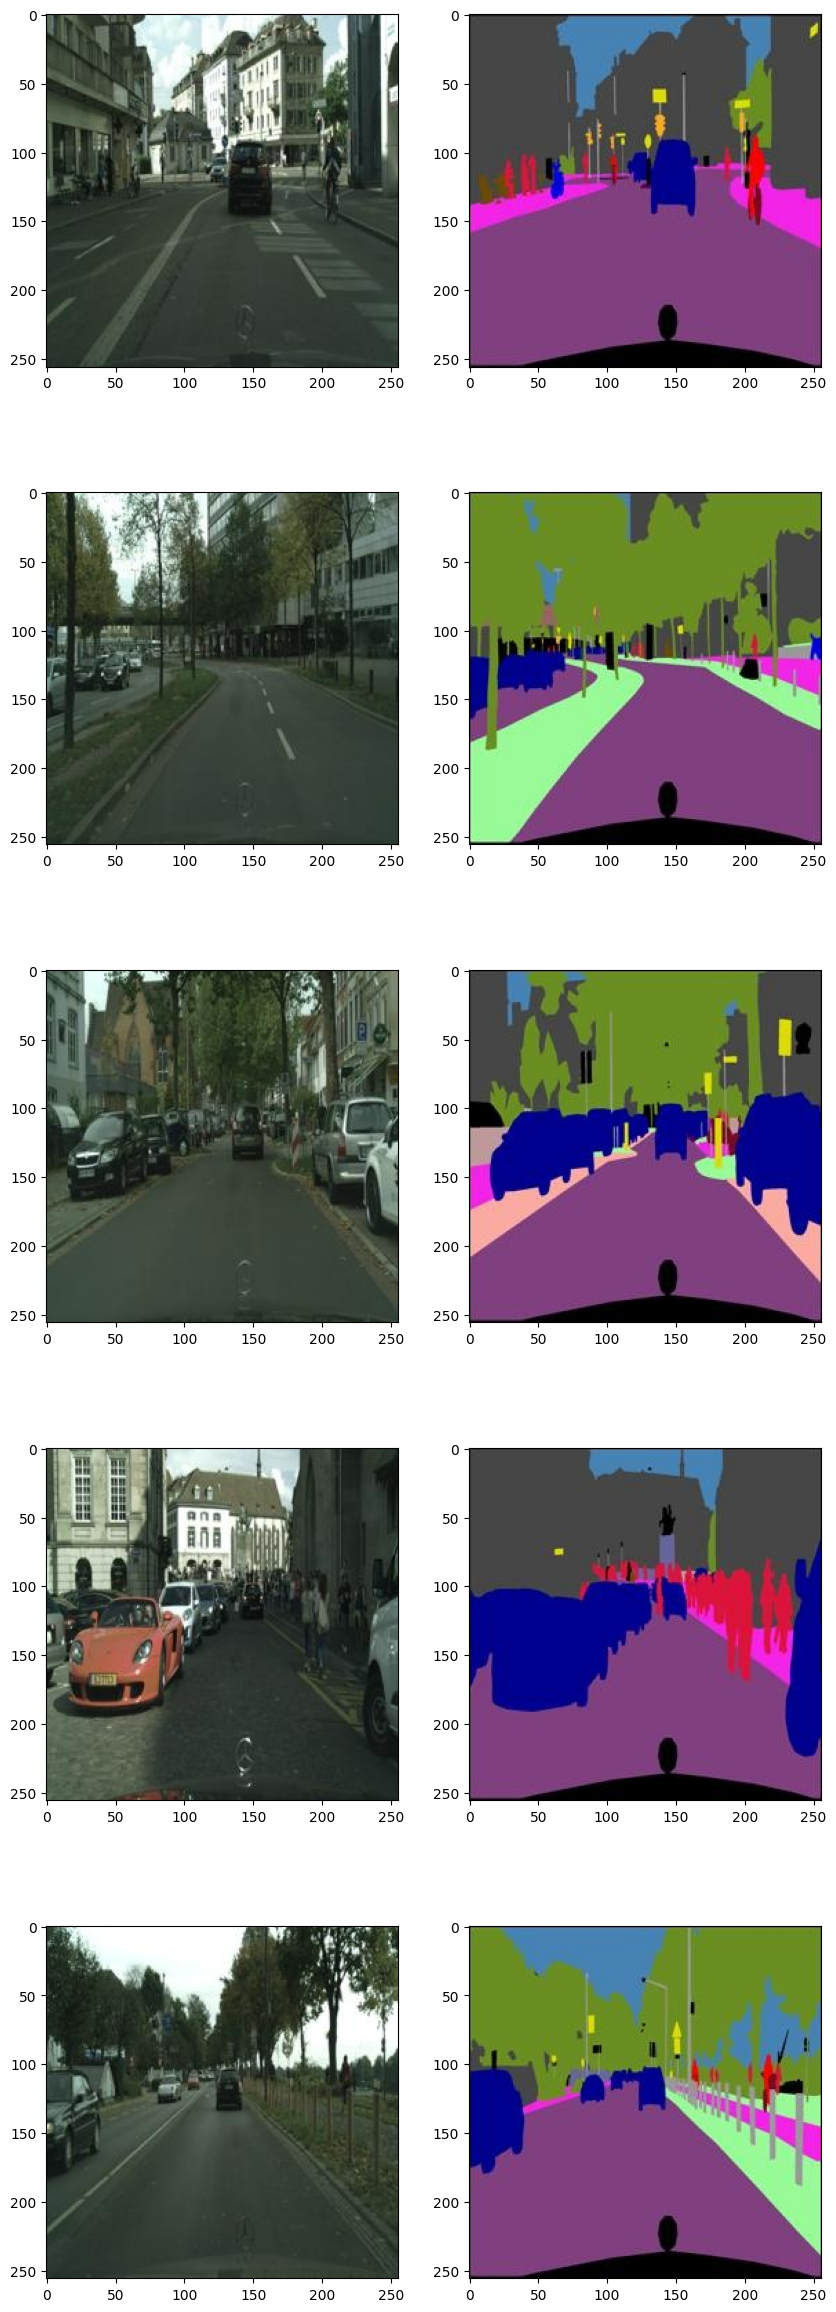

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(10,30))
for i in range(5):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:,:256])
    ax[i][1].imshow(img[:,256:])

### Defining Custom Dataset

In [ ]:
train_dataset = []
validation_dataset = []

In [ ]:
class MyDataset(Dataset):

    def __init__(self, images_path ,transform_img=None ,transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

### Defining the Transfoms

In [ ]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor(),
        #transform.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transform.RandomHorizontalFlip(p=0.9)
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)

In [ ]:
# train dataset
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [ ]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
vaild_loader = DataLoader(valdata,1)

torch.save(train_loader,'train_loader.pth')
torch.save(vaild_loader,'valid_loader.pth')

In [ ]:
traindata.__getitem__(0)[0].shape,traindata.__getitem__(0)[1].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [ ]:
# inverse_transform = transform.Compose([
#     transform.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
# ])


In [ ]:

'''
    This is a helper function.
    This will help in ploting the masked got from the model.

'''
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))

    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

# Building UNet Model Architecture


<br>

![unet2.png](attachment:6c6d6226-92c1-48dd-8235-68c8c378b5ba.png)

In [ ]:
'''

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

'''

class Convblock(nn.Module):

      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )


      def forward(self,x):
        x = self.convblock(x)
        return x

In [ ]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):

    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain

    def forward(self,x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out

    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)




In [ ]:
import torch.nn as nn
import torch
import torchvision.models
import torch.nn.functional as F
# from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet34, ResNet34_Weights


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None,dilation1=1,dilation2=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False,dilation=dilation1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False,dilation=dilation2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels,dilation1=1,dilation2=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels,dilation1=dilation1,dilation2=dilation2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


# class DownAtrous(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             DoubleConv(in_channels, out_channels,dilation=2)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)





class UNet(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        super(UNet, self).__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits





class Dilation1(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        super().__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64,dilation1=1,dilation2=1))
        self.down1 = (Down(64, 128,dilation1=2,dilation2=1))
        self.down2 = (Down(128, 256,dilation1=2,dilation2=1))
        self.down3 = (Down(256, 512,dilation1=2,dilation2=1))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class Dilation2(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        super().__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64,dilation1=1,dilation2=1))
        self.down1 = (Down(64, 128,dilation1=2,dilation2=2))
        self.down2 = (Down(128, 256,dilation1=2,dilation2=2))
        self.down3 = (Down(256, 512,dilation1=2,dilation2=2))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



class UNet2Layer(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        print("--------------2layers------------")
        super().__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64))
        self.down1 = (Down(64, 128))
        factor = 2 if bilinear else 1
        # self.down2 = (Down(128, 256))
        # self.down3 = (Down(256, 512))
        self.down2 = (Down(128, 256 // factor))
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        # self.up2 = (Up(512, 256 // factor, bilinear))
        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        # x4 = self.down3(x3)
        # x5 = self.down4(x4)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        # x = self.up3(x, x2)
        # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class UNet2LayerDilation(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        print("--------------2layers------------")
        super().__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64))
        self.down1 = (Down(64, 128,dilation1=2,dilation2=2))
        factor = 2 if bilinear else 1
        # self.down2 = (Down(128, 256))
        # self.down3 = (Down(256, 512))
        self.down2 = (Down(128, 256 // factor,dilation1=2,dilation2=2))
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        # self.up2 = (Up(512, 256 // factor, bilinear))
        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        # x4 = self.down3(x3)
        # x5 = self.down4(x4)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        # x = self.up3(x, x2)
        # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_ReLU=True):
        super().__init__()
        self.use_ReLU=use_ReLU

        if use_ReLU:
            self.layers= nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        else:
            self.layers= nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        return self.layers(x)





# class Residual2LayerUNet(nn.Module):
#     def __init__(self, n_classes, load_pretrained_encoder_layers=False):
#         super().__init__()

#         if load_pretrained_encoder_layers:
#             resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
#             l1=resnet.layer1
#             l2=resnet.layer2

#             for param in l1.parameters():
#                 param.requires_grad = False

#             for param in l2.parameters():
#                 param.requires_grad = False
#         else:
#             resnet=resnet34(weights=None)
#             l1=resnet.layer1
#             l2=resnet.layer2

#         self.resnet=resnet
#         self.base_layers = list(self.resnet.children())

#         ## 0. Pre layer
#         self.pre_layer=nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#         ## 1. Encoder containing layers of Resnet
#         self.encoder_l1 = l1

#         self.encoder_l2 = l2
#         # self.encoder_l3 = resnet.layer3
#         # self.encoder_l4 = resnet.layer4


#         # 2. Decoder layers
#         x, y = 10, 10
#         # self.decoder_l1 = DecoderBlock(512,256//2)
#         # self.decoder_l2 = DecoderBlock(384,128//2)
#         self.decoder_l3 = DecoderBlock(128,64//2)
#         self.decoder_l4 = DecoderBlock(96,64//2)

#         # 3. Out layer
#         self.out_layer = DecoderBlock(35,n_classes,use_ReLU=False)


#     def forward(self, iput):
#         # print("iput:",iput.shape)
#         preout=self.pre_layer(iput)
#         # print("preout:",preout.shape)
#         eout1=self.encoder_l1(preout)
#         # print("eout1:",eout1.shape)
#         eout2=self.encoder_l2(eout1)
#         # print("eout2:",eout2.shape)
#         # eout3=self.encoder_l3(eout2)
#         # # print("eout3:",eout3.shape)
#         # eout4=self.encoder_l4(eout3)
#         # print("eout4:",eout4.shape)

#         # dout1=self.decoder_l1(eout4)
#         # dout1=torch.cat([dout1,eout3],1)
#         # # print("dout1:",dout1.shape)

#         # dout2=self.decoder_l2(dout1)
#         # dout2=torch.cat([dout2,eout2],1)
#         # print("dout2:",dout2.shape)

#         dout3=self.decoder_l3(eout2)
#         dout3=torch.cat([dout3,eout1],1)
#         # print("dout3:",dout3.shape)

#         dout4=self.decoder_l4(dout3)
#         dout4=torch.cat([dout4,iput],1)
#         # print("dout4:",dout4.shape)

#         out=self.out_layer(dout4)
#         # print("out:",out.shape)
# #
#         return out


class Residual2LayerUNet(nn.Module):
    def __init__(self, n_classes, bilinear=False,load_pretrained_encoder_layers=False):
        print("--------------------------------------------------PRE LOADED",load_pretrained_encoder_layers)

        if load_pretrained_encoder_layers:
            resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
            l1=resnet.layer1
            l2=resnet.layer2

            for param in l1.parameters():
                param.requires_grad = False

            for param in l2.parameters():
                param.requires_grad = False
        else:
            resnet=resnet34(weights=None)
            l1=resnet.layer1
            l2=resnet.layer2


        super().__init__()
        self.n_channels = 3
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_layers = []

        self.inc = (DoubleConv(3, 64))
        self.down1 = l1
        factor = 2 if bilinear else 1
        self.down2 = l2
        self.up1 = (Up(128, 128 // factor, bilinear))
        self.up2 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        # print("x1",x1.shape)
        x2 = self.down1(x1)
        # print("x2",x2.shape)
        x3 = self.down2(x2)
        # print("x3",x3.shape)
        x = self.up1(x3, x2)
        # print("x",x.shape)
        x = self.up2(x, x1)
        # print("x",x.shape)
        logits = self.outc(x)
        # print("logits",logits.shape)
        return logits

In [ ]:
# initializing the model
model = UNet(3).float().to(device)

In [ ]:
lr = 0.01
epochs = 15

In [ ]:
# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

### Creating the traning loop

In [ ]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(vaild_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model, "city_unet_15epoch.pth")

# Ploting the Training VS Validation Loss Curve

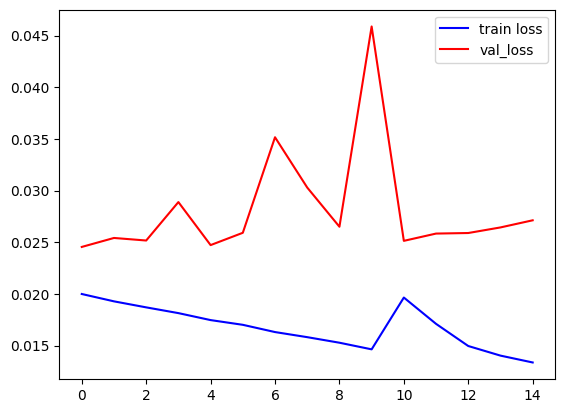

In [ ]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()

# Visualizing the Results

In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()

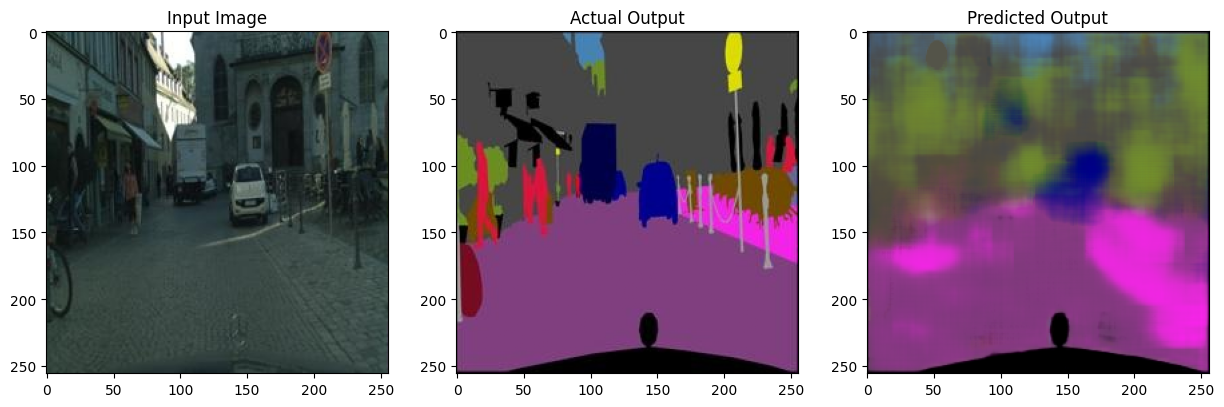

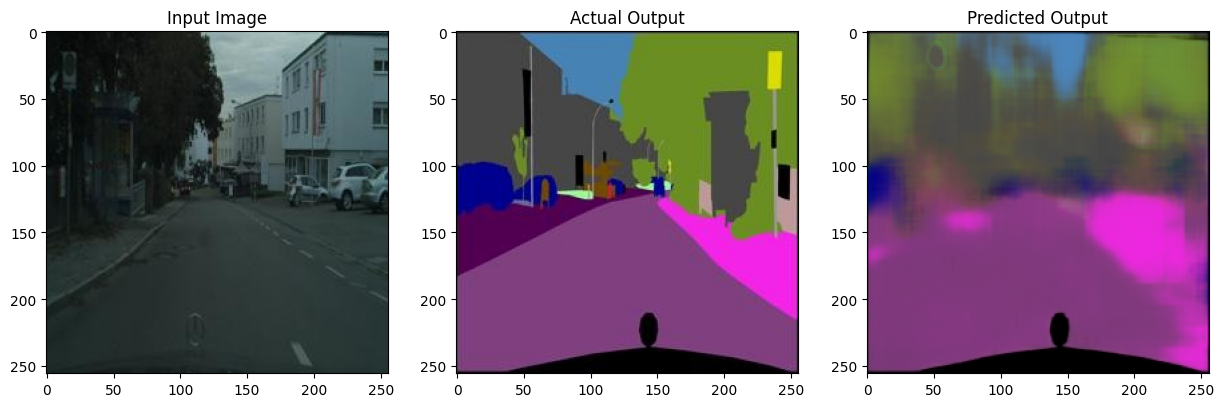

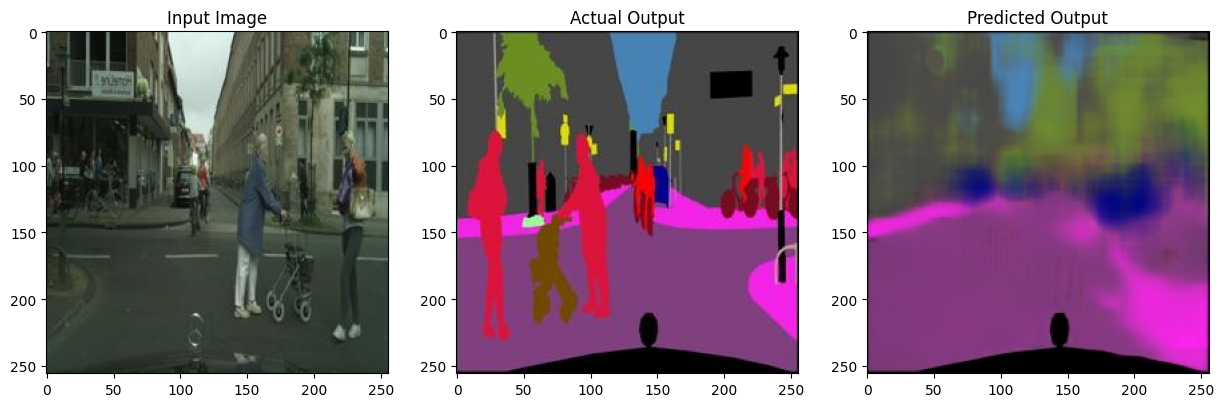

In [ ]:
c = 0
for img,label in (vaild_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        show(img,output,label)
        if c>1:
            break
        c+=1